# Elliptic Address-Based Graph - Exploratory Data Analysis

Comprehensive EDA of the address-based Bitcoin transaction graph derived from the Elliptic dataset.

**Dataset**: 823K+ addresses, 49 timesteps, transaction flows with BTC amounts

**Key Focus**: Understanding address behavior, illicit vs licit patterns, network structure, temporal evolution

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
DATA_DIR = Path('processed_data/address_graphs')

print("Libraries loaded")

Libraries loaded


---
## Section 1: Data Overview & Quality Checks

In [81]:
# Load all datasets
print("Loading datasets...")

labels_df = pd.read_csv(DATA_DIR / 'address_labels.csv')
features_df = pd.read_csv(DATA_DIR / 'address_features.csv')
edges_df = pd.read_csv(DATA_DIR / 'address_edgelist.csv')
timestep_stats_df = pd.read_csv(DATA_DIR / 'timestep_stats.csv')

# Merge labels with features
df = features_df.merge(labels_df, on=['address', 'idx'], how='left')

print(f" Loaded {len(df):,} addresses")
print(f" Loaded {len(edges_df):,} edges")
print(f" Loaded {len(timestep_stats_df)} timesteps")

Loading datasets...
 Loaded 823,276 addresses
 Loaded 3,359,159 edges
 Loaded 49 timesteps


In [82]:
# Dataset summary
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total addresses:     {len(df):,}")
print(f"Total edges:         {len(edges_df):,}")
print(f"Timesteps:           {timestep_stats_df['timestep'].min()} to {timestep_stats_df['timestep'].max()}")
print(f"\nData shapes:")
print(f"  Labels:            {labels_df.shape}")
print(f"  Features:          {features_df.shape}")
print(f"  Edges:             {edges_df.shape}")
print(f"\nMemory usage:")
print(f"  Labels:            {labels_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"  Features:          {features_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"  Edges:             {edges_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

DATASET SUMMARY
Total addresses:     823,276
Total edges:         3,359,159
Timesteps:           1 to 49

Data shapes:
  Labels:            (823276, 11)
  Features:          (823276, 21)
  Edges:             (3359159, 5)

Memory usage:
  Labels:            164.6 MB
  Features:          190.8 MB
  Edges:             608.5 MB



LABEL DISTRIBUTION

Absolute counts:
label
unknown    650428
2          161150
1           11698
Name: count, dtype: int64

Percentages:
label
unknown    79.004854
2          19.574238
1           1.420909
Name: proportion, dtype: float64


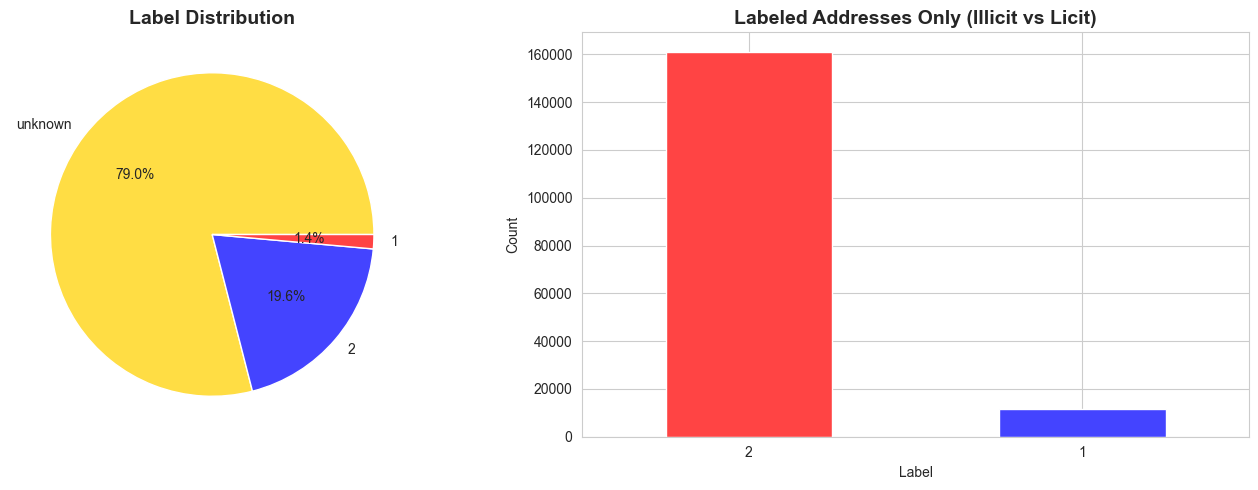

In [83]:
# Label distribution
print("\n" + "="*60)
print("LABEL DISTRIBUTION")
print("="*60)

label_counts = df['label'].value_counts()
print("\nAbsolute counts:")
print(label_counts)

print("\nPercentages:")
print(df['label'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = {'1': '#FF4444', '2': '#4444FF', 'unknown': '#FFDD44'}
label_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                  colors=[colors.get(str(x), '#gray') for x in label_counts.index])
axes[0].set_title('Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Bar chart (excluding unknown for better visibility)
labeled_only = df[df['label'] != 'unknown']['label'].value_counts()
labeled_only.plot(kind='bar', ax=axes[1], color=['#FF4444', '#4444FF'])
axes[1].set_title('Labeled Addresses Only (Illicit vs Licit)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


CONFIDENCE SCORE ANALYSIS

Addresses with labels: 172,848
Average confidence: 1.0000
Median confidence:  1.0000

Confidence distribution:
count    172848.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: confidence, dtype: float64


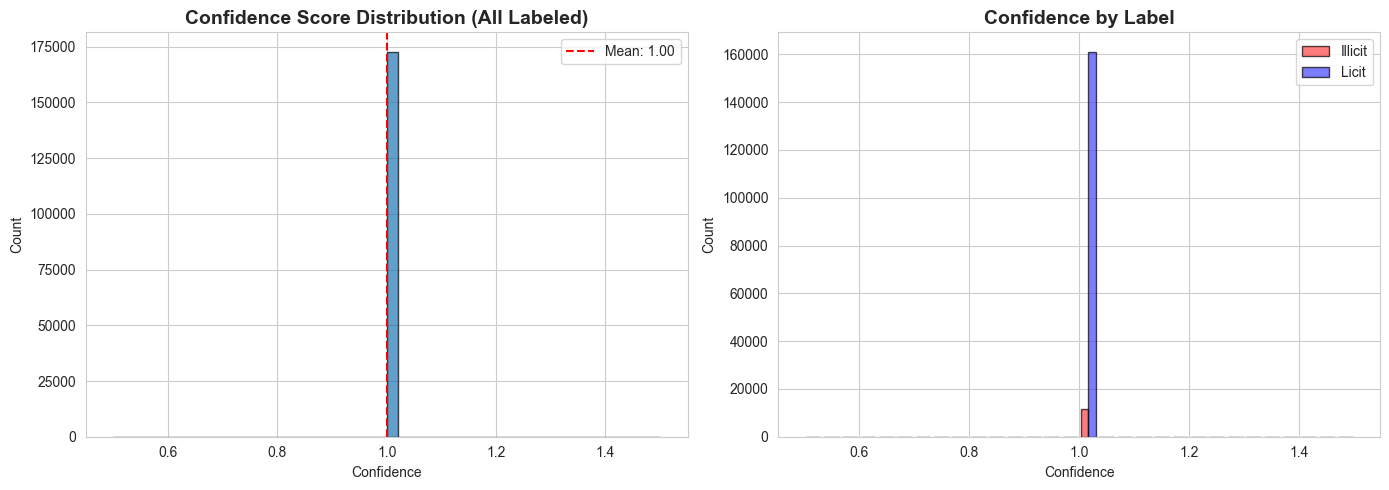

In [84]:
# Confidence score distribution
print("\n" + "="*60)
print("CONFIDENCE SCORE ANALYSIS")
print("="*60)

labeled = df[df['label'] != 'unknown']
print(f"\nAddresses with labels: {len(labeled):,}")
print(f"Average confidence: {labeled['confidence'].mean():.4f}")
print(f"Median confidence:  {labeled['confidence'].median():.4f}")
print(f"\nConfidence distribution:")
print(labeled['confidence'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confidence histogram
axes[0].hist(labeled['confidence'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Confidence Score Distribution (All Labeled)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].axvline(labeled['confidence'].mean(), color='red', linestyle='--', label=f'Mean: {labeled["confidence"].mean():.2f}')
axes[0].legend()

# Confidence by label
illicit_conf = labeled[labeled['label'] == '1']['confidence']
licit_conf = labeled[labeled['label'] == '2']['confidence']

axes[1].hist([illicit_conf, licit_conf], bins=30, label=['Illicit', 'Licit'], 
             color=['#FF4444', '#4444FF'], alpha=0.7, edgecolor='black')
axes[1].set_title('Confidence by Label', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()


ADDRESS ROLE ANALYSIS (Input vs Output)

Addresses that ONLY received (never sent): 423,066
Addresses that ONLY sent (never received): 181,871
Addresses that both sent and received:     218,339

Labeling breakdown:
  Addresses with labeled INPUT transactions:  172,848
  Addresses with labeled OUTPUT transactions: 207,277


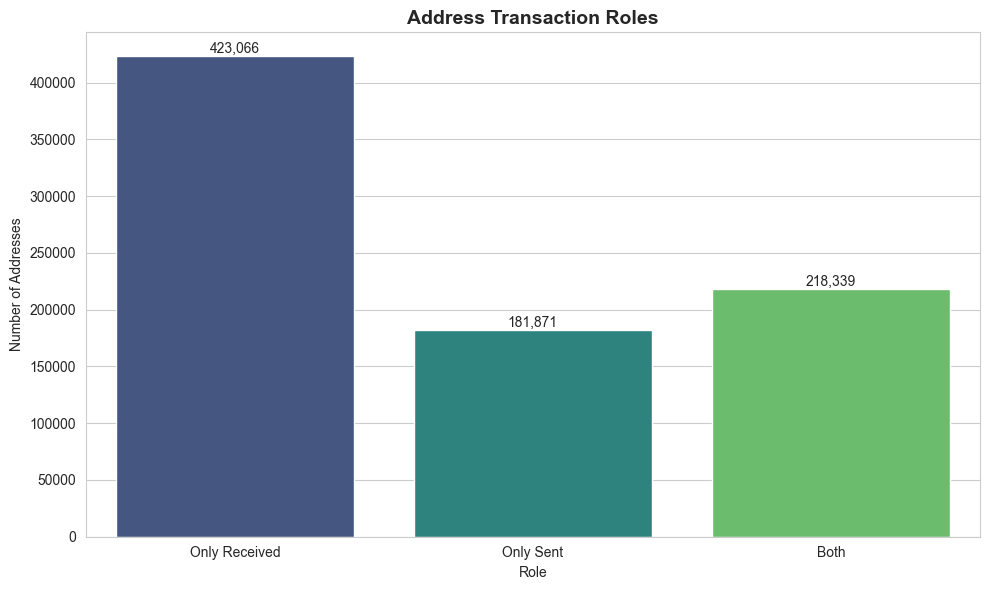

In [85]:
# Input vs Output analysis
print("\n" + "="*60)
print("ADDRESS ROLE ANALYSIS (Input vs Output)")
print("="*60)

print(f"\nAddresses that ONLY received (never sent): {(df['num_input_txs'] == 0).sum():,}")
print(f"Addresses that ONLY sent (never received): {(df['num_output_txs'] == 0).sum():,}")
print(f"Addresses that both sent and received:     {((df['num_input_txs'] > 0) & (df['num_output_txs'] > 0)).sum():,}")

print(f"\nLabeling breakdown:")
print(f"  Addresses with labeled INPUT transactions:  {(df['num_illicit_input_txs'] + df['num_licit_input_txs'] > 0).sum():,}")
print(f"  Addresses with labeled OUTPUT transactions: {(df['num_illicit_output_txs'] + df['num_licit_output_txs'] > 0).sum():,}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

role_data = pd.DataFrame({
    'Role': ['Only Received', 'Only Sent', 'Both'],
    'Count': [
        (df['num_input_txs'] == 0).sum(),
        (df['num_output_txs'] == 0).sum(),
        ((df['num_input_txs'] > 0) & (df['num_output_txs'] > 0)).sum()
    ]
})

sns.barplot(data=role_data, x='Role', y='Count', ax=ax, palette='viridis')
ax.set_title('Address Transaction Roles', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Addresses')

for i, v in enumerate(role_data['Count']):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---
## Section 2: Address-Level Statistics

In [86]:
# Activity metrics
print("="*60)
print("ACTIVITY METRICS")
print("="*60)

print("\nTransaction count statistics:")
print(df['num_transactions_x'].describe())

print("\nBTC volume statistics:")
print("\nBTC Sent:")
print(df['total_btc_sent'].describe())
print("\nBTC Received:")
print(df['total_btc_received'].describe())

print(f"\nTop 10 most active addresses (by transaction count):")
print(df.nlargest(10, 'num_transactions_x')[['address', 'num_transactions_x', 'label', 'total_btc_sent', 'total_btc_received']])

ACTIVITY METRICS

Transaction count statistics:
count    823276.000000
mean          1.686792
std           9.454813
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2932.000000
Name: num_transactions_x, dtype: float64

BTC volume statistics:

BTC Sent:
count    823276.000000
mean         20.962335
std         546.703101
min           0.000000
25%           0.000000
50%           0.000000
75%           1.568867
max      293550.613877
Name: total_btc_sent, dtype: float64

BTC Received:
count    823276.000000
mean         87.590634
std        1198.019136
min           0.000000
25%           0.013640
50%           0.657146
75%          12.311315
max      369128.912835
Name: total_btc_received, dtype: float64

Top 10 most active addresses (by transaction count):
                                   address  num_transactions_x    label  \
61348   13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv                2932        2   
791612  3JnFBLxDCutY3bZEZsP

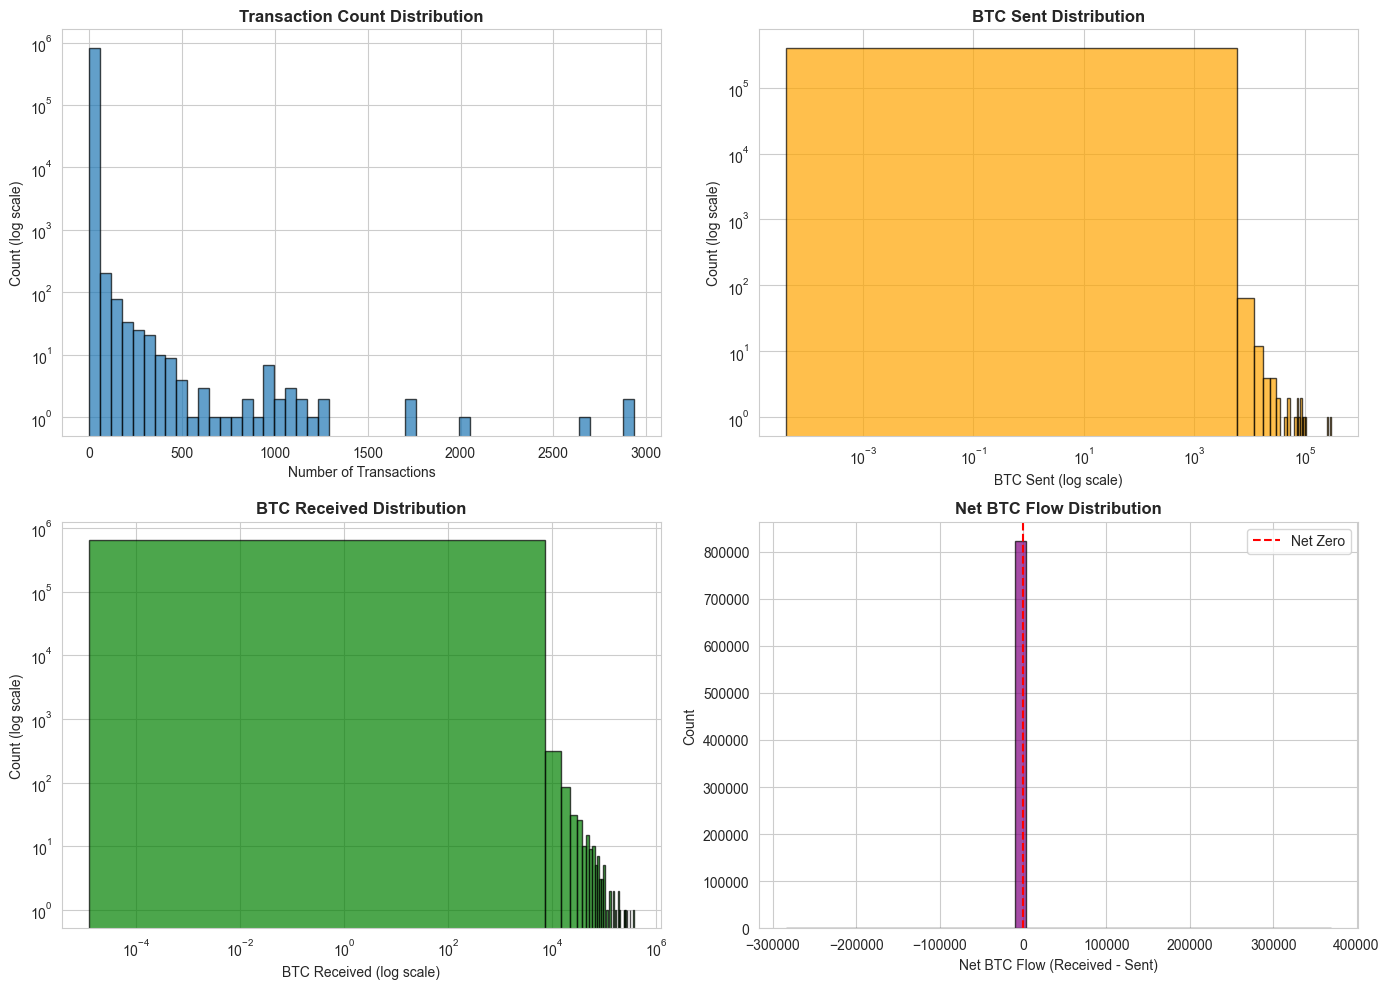

In [87]:
# Visualize activity distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transaction count distribution (log scale)
axes[0, 0].hist(df[df['num_transactions_x'] > 0]['num_transactions_x'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Transaction Count Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Transactions')
axes[0, 0].set_ylabel('Count (log scale)')

# BTC sent distribution (log-log)
sent_positive = df[df['total_btc_sent'] > 0]['total_btc_sent']
axes[0, 1].hist(sent_positive, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('BTC Sent Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('BTC Sent (log scale)')
axes[0, 1].set_ylabel('Count (log scale)')

# BTC received distribution (log-log)
received_positive = df[df['total_btc_received'] > 0]['total_btc_received']
axes[1, 0].hist(received_positive, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('BTC Received Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('BTC Received (log scale)')
axes[1, 0].set_ylabel('Count (log scale)')

# Net flow distribution
axes[1, 1].hist(df['net_btc_flow'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(0, color='red', linestyle='--', label='Net Zero')
axes[1, 1].set_title('Net BTC Flow Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Net BTC Flow (Received - Sent)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


TEMPORAL PATTERNS

One-time addresses (active in only 1 timestep): 761,565 (92.5%)
Multi-time addresses (active in >1 timestep):   61,711 (7.5%)

Label breakdown for multi-time addresses:
  Fraud       : 97 (0.2%)
  Non-fraud   : 18,238 (29.6%)
  Unknown     : 43,376 (70.3%)


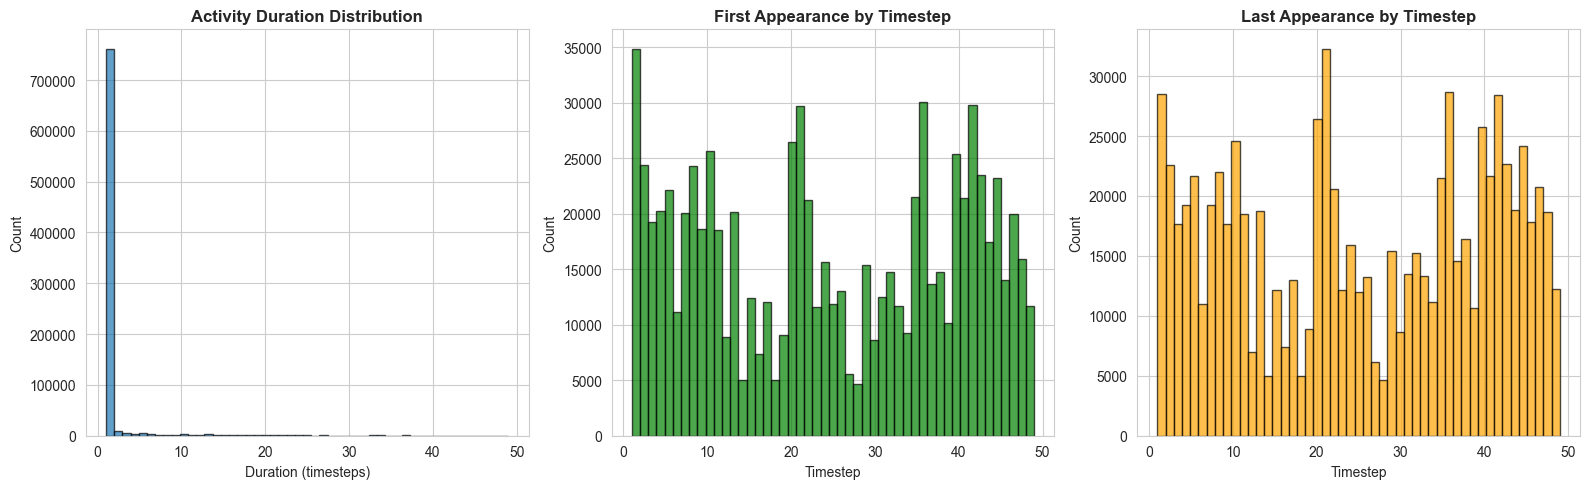

In [88]:
# Temporal patterns
print("\n" + "="*60)
print("TEMPORAL PATTERNS")
print("="*60)

# One-time vs multi-time addresses
one_time = df[df['activity_duration'] == 1]
multi_time = df[df['activity_duration'] > 1]

print(f"\nOne-time addresses (active in only 1 timestep): {len(one_time):,} ({len(one_time) / len(df) * 100:.1f}%)")
print(f"Multi-time addresses (active in >1 timestep):   {len(multi_time):,} ({len(multi_time) / len(df) * 100:.1f}%)")

print(f"\nLabel breakdown for multi-time addresses:")
multi_time_labels = multi_time['label'].value_counts()
for label in ['1', '2', 'unknown']:
    count = multi_time_labels.get(label, 0)
    pct = (count / len(multi_time) * 100) if len(multi_time) > 0 else 0
    label_name = 'Fraud' if label == '1' else ('Non-fraud' if label == '2' else 'Unknown')
    print(f"  {label_name:12s}: {count:,} ({pct:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Activity duration
axes[0].hist(df['activity_duration'], bins=49, edgecolor='black', alpha=0.7)
axes[0].set_title('Activity Duration Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Duration (timesteps)')
axes[0].set_ylabel('Count')

# First appearance
axes[1].hist(df['first_timestep'], bins=49, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('First Appearance by Timestep', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Count')

# Last appearance
axes[2].hist(df['last_timestep'], bins=49, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_title('Last Appearance by Timestep', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [89]:
# Network metrics
print("\n" + "="*60)
print("NETWORK METRICS")
print("="*60)

print("\nDegree statistics:")
print("\nOut-degree:")
print(df['out_degree'].describe())
print("\nIn-degree:")
print(df['in_degree'].describe())
print("\nTotal degree (in + out):")
df['total_degree'] = df['in_degree'] + df['out_degree']
print(df['total_degree'].describe())

print(f"\nIsolated addresses (degree 0):   {(df['total_degree'] == 0).sum():,}")
print(f"High-degree addresses (degree 100+): {(df['total_degree'] >= 100).sum():,}")

print(f"\nTop 10 addresses by total degree:")
print(df.nlargest(10, 'total_degree')[['address', 'in_degree', 'out_degree', 'total_degree', 'label']])


NETWORK METRICS

Degree statistics:

Out-degree:
count    823276.000000
mean          4.080234
std         266.269156
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      233233.000000
Name: out_degree, dtype: float64

In-degree:
count    823276.000000
mean          4.080234
std          26.000793
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       12307.000000
Name: in_degree, dtype: float64

Total degree (in + out):
count    823276.000000
mean          8.160469
std         268.340013
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      233255.000000
Name: total_degree, dtype: float64

Isolated addresses (degree 0):   0
High-degree addresses (degree 100+): 7,250

Top 10 addresses by total degree:
                                   address  in_degree  out_degree  \
202510  18WYMeJ4cxoeb7LxWHMxayuJGVBWfGjckD         22      233233   
449105  

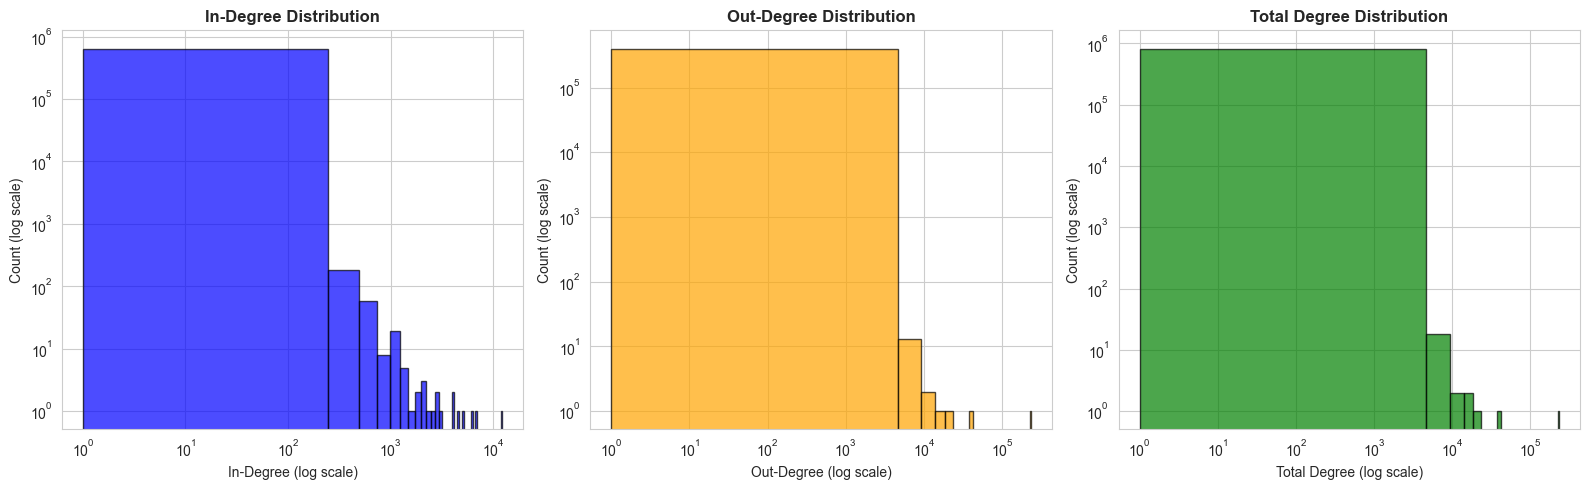

In [90]:
# Visualize degree distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# In-degree (log-log)
in_deg_positive = df[df['in_degree'] > 0]['in_degree']
axes[0].hist(in_deg_positive, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('In-Degree Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('In-Degree (log scale)')
axes[0].set_ylabel('Count (log scale)')

# Out-degree (log-log)
out_deg_positive = df[df['out_degree'] > 0]['out_degree']
axes[1].hist(out_deg_positive, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Out-Degree Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Out-Degree (log scale)')
axes[1].set_ylabel('Count (log scale)')

# Total degree (log-log)
total_deg_positive = df[df['total_degree'] > 0]['total_degree']
axes[2].hist(total_deg_positive, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title('Total Degree Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Total Degree (log scale)')
axes[2].set_ylabel('Count (log scale)')

plt.tight_layout()
plt.show()

---
## Section 3: Illicit vs Licit Comparison

In [91]:
# Prepare labeled data
illicit = df[df['label'] == '1']
licit = df[df['label'] == '2']

print("="*60)
print("ILLICIT VS LICIT COMPARISON")
print("="*60)
print(f"\nIllicit addresses: {len(illicit):,}")
print(f"Licit addresses:   {len(licit):,}")
print(f"Ratio:             1:{len(licit)/len(illicit):.1f}")

ILLICIT VS LICIT COMPARISON

Illicit addresses: 11,698
Licit addresses:   161,150
Ratio:             1:13.8


In [92]:
# Activity comparison
print("\n" + "="*60)
print("ACTIVITY COMPARISON")
print("="*60)

print("\nTransaction Count:")
print(f"  Illicit - Mean: {illicit['num_transactions_x'].mean():.2f}, Median: {illicit['num_transactions_x'].median():.1f}")
print(f"  Licit   - Mean: {licit['num_transactions_x'].mean():.2f}, Median: {licit['num_transactions_x'].median():.1f}")

print("\nBTC Sent:")
print(f"  Illicit - Mean: {illicit['total_btc_sent'].mean():.4f}, Median: {illicit['total_btc_sent'].median():.4f}")
print(f"  Licit   - Mean: {licit['total_btc_sent'].mean():.4f}, Median: {licit['total_btc_sent'].median():.4f}")

print("\nBTC Received:")
print(f"  Illicit - Mean: {illicit['total_btc_received'].mean():.4f}, Median: {illicit['total_btc_received'].median():.4f}")
print(f"  Licit   - Mean: {licit['total_btc_received'].mean():.4f}, Median: {licit['total_btc_received'].median():.4f}")

# Statistical test
from scipy import stats
stat, p_value = stats.mannwhitneyu(illicit['num_transactions_x'], licit['num_transactions_x'])
print(f"\nMann-Whitney U test (transaction count): p-value = {p_value:.4e}")
if p_value < 0.05:
    print("  ' Statistically significant difference (p < 0.05)")
else:
    print("  ' No significant difference (p >= 0.05)")


ACTIVITY COMPARISON

Transaction Count:
  Illicit - Mean: 1.86, Median: 2.0
  Licit   - Mean: 2.13, Median: 2.0

BTC Sent:
  Illicit - Mean: 2.5330, Median: 1.0639
  Licit   - Mean: 56.8804, Median: 4.7755

BTC Received:
  Illicit - Mean: 4.6424, Median: 0.1446
  Licit   - Mean: 59.4387, Median: 0.0000

Mann-Whitney U test (transaction count): p-value = 5.2184e-113
  ' Statistically significant difference (p < 0.05)


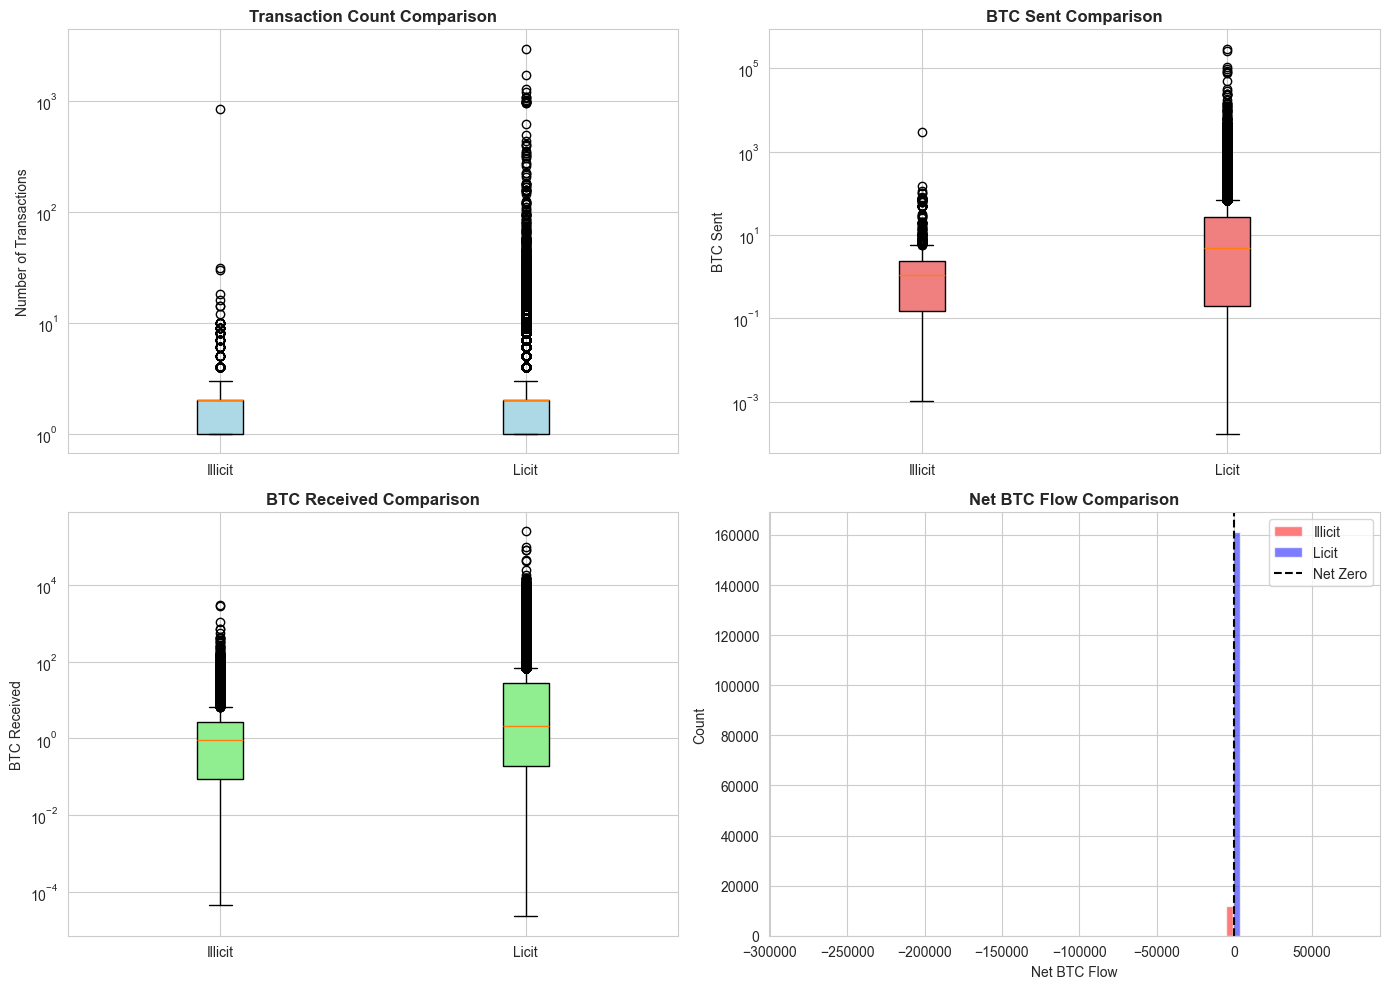

In [93]:
# Visualize activity comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transaction count box plot
data_to_plot = [illicit['num_transactions_x'], licit['num_transactions_x']]
axes[0, 0].boxplot(data_to_plot, labels=['Illicit', 'Licit'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue'))
axes[0, 0].set_title('Transaction Count Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].set_yscale('log')

# BTC sent box plot
data_to_plot = [illicit[illicit['total_btc_sent'] > 0]['total_btc_sent'], 
                licit[licit['total_btc_sent'] > 0]['total_btc_sent']]
axes[0, 1].boxplot(data_to_plot, labels=['Illicit', 'Licit'], patch_artist=True,
                   boxprops=dict(facecolor='lightcoral'))
axes[0, 1].set_title('BTC Sent Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('BTC Sent')
axes[0, 1].set_yscale('log')

# BTC received box plot
data_to_plot = [illicit[illicit['total_btc_received'] > 0]['total_btc_received'], 
                licit[licit['total_btc_received'] > 0]['total_btc_received']]
axes[1, 0].boxplot(data_to_plot, labels=['Illicit', 'Licit'], patch_artist=True,
                   boxprops=dict(facecolor='lightgreen'))
axes[1, 0].set_title('BTC Received Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('BTC Received')
axes[1, 0].set_yscale('log')

# Net flow comparison
axes[1, 1].hist([illicit['net_btc_flow'], licit['net_btc_flow']], 
                bins=30, label=['Illicit', 'Licit'], alpha=0.7, color=['#FF4444', '#4444FF'])
axes[1, 1].axvline(0, color='black', linestyle='--', label='Net Zero')
axes[1, 1].set_title('Net BTC Flow Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Net BTC Flow')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


NETWORK BEHAVIOR COMPARISON

Degree Statistics:
  Illicit - In-degree:  Mean=1.57, Median=1.0
  Licit   - In-degree:  Mean=2.92, Median=0.0

  Illicit - Out-degree: Mean=1.37, Median=1.0
  Licit   - Out-degree: Mean=11.19, Median=2.0

Counterparties:
  Illicit - Mean: 2.81
  Licit   - Mean: 12.40


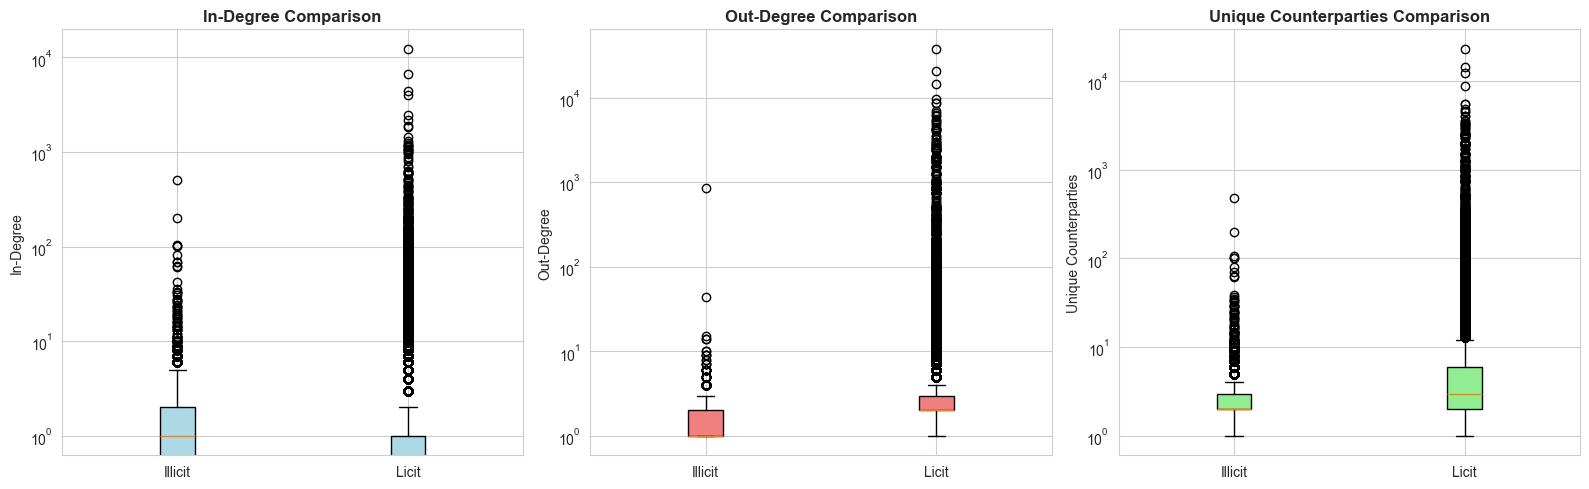

In [94]:
# Network behavior comparison
print("\n" + "="*60)
print("NETWORK BEHAVIOR COMPARISON")
print("="*60)

print("\nDegree Statistics:")
print(f"  Illicit - In-degree:  Mean={illicit['in_degree'].mean():.2f}, Median={illicit['in_degree'].median():.1f}")
print(f"  Licit   - In-degree:  Mean={licit['in_degree'].mean():.2f}, Median={licit['in_degree'].median():.1f}")
print(f"\n  Illicit - Out-degree: Mean={illicit['out_degree'].mean():.2f}, Median={illicit['out_degree'].median():.1f}")
print(f"  Licit   - Out-degree: Mean={licit['out_degree'].mean():.2f}, Median={licit['out_degree'].median():.1f}")

print("\nCounterparties:")
print(f"  Illicit - Mean: {illicit['unique_counterparties'].mean():.2f}")
print(f"  Licit   - Mean: {licit['unique_counterparties'].mean():.2f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# In-degree comparison
axes[0].boxplot([illicit['in_degree'], licit['in_degree']], labels=['Illicit', 'Licit'],
                patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[0].set_title('In-Degree Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('In-Degree')
axes[0].set_yscale('log')

# Out-degree comparison
axes[1].boxplot([illicit['out_degree'], licit['out_degree']], labels=['Illicit', 'Licit'],
                patch_artist=True, boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Out-Degree Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Out-Degree')
axes[1].set_yscale('log')

# Counterparties comparison
axes[2].boxplot([illicit['unique_counterparties'], licit['unique_counterparties']], 
                labels=['Illicit', 'Licit'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[2].set_title('Unique Counterparties Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Unique Counterparties')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


TEMPORAL BEHAVIOR COMPARISON

Activity Duration:
  Illicit - Mean: 1.07, Median: 1.0
  Licit   - Mean: 2.27, Median: 1.0

One-time addresses:
  Illicit: 11601 (99.2%)
  Licit:   142912 (88.7%)


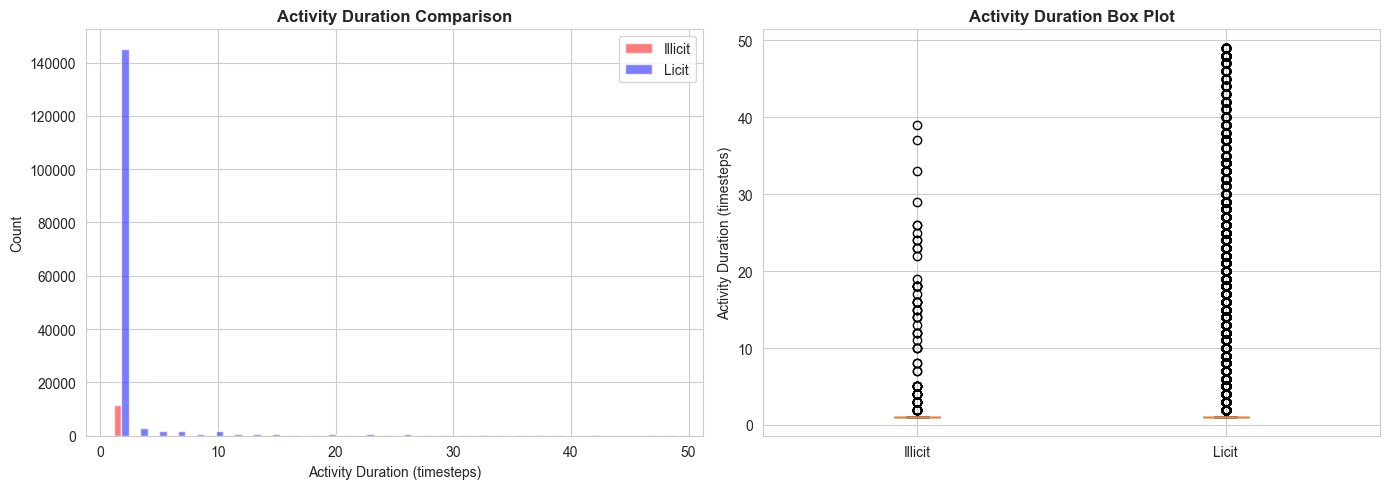

In [95]:
# Temporal behavior comparison
print("\n" + "="*60)
print("TEMPORAL BEHAVIOR COMPARISON")
print("="*60)

print("\nActivity Duration:")
print(f"  Illicit - Mean: {illicit['activity_duration'].mean():.2f}, Median: {illicit['activity_duration'].median():.1f}")
print(f"  Licit   - Mean: {licit['activity_duration'].mean():.2f}, Median: {licit['activity_duration'].median():.1f}")

print(f"\nOne-time addresses:")
print(f"  Illicit: {(illicit['activity_duration'] == 1).sum()} ({(illicit['activity_duration'] == 1).sum() / len(illicit) * 100:.1f}%)")
print(f"  Licit:   {(licit['activity_duration'] == 1).sum()} ({(licit['activity_duration'] == 1).sum() / len(licit) * 100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Activity duration comparison
axes[0].hist([illicit['activity_duration'], licit['activity_duration']], 
             bins=30, label=['Illicit', 'Licit'], alpha=0.7, color=['#FF4444', '#4444FF'])
axes[0].set_title('Activity Duration Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Activity Duration (timesteps)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Box plot
axes[1].boxplot([illicit['activity_duration'], licit['activity_duration']], 
                labels=['Illicit', 'Licit'], patch_artist=True, boxprops=dict(facecolor='lightyellow'))
axes[1].set_title('Activity Duration Box Plot', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Activity Duration (timesteps)')

plt.tight_layout()
plt.show()

---
## Section 4: Graph Structure Analysis

In [97]:
# Get all numeric feature columns
print("="*60)
print("ALL FEATURES COMPARISON: ILLICIT VS LICIT")
print("="*60)

# Define all available features (excluding metadata and label columns)
all_features = [col for col in df.columns if col not in [
    'address', 'idx', 'label', 'confidence', 
    'num_transactions_y', 'num_input_txs', 'num_output_txs',
    'num_illicit_input_txs', 'num_licit_input_txs',
    'num_illicit_output_txs', 'num_licit_output_txs', 'total_degree'
]]

print(f"\nAnalyzing {len(all_features)} features:")
print(all_features)

# Compute statistics for each feature
feature_stats = []
for feature in all_features:
    illicit_mean = illicit[feature].mean()
    licit_mean = licit[feature].mean()
    illicit_median = illicit[feature].median()
    licit_median = licit[feature].median()
    
    # Mann-Whitney U test
    try:
        stat, p_value = stats.mannwhitneyu(illicit[feature].dropna(), licit[feature].dropna())
        significant = "YES" if p_value < 0.05 else "NO"
    except:
        p_value = np.nan
        significant = "N/A"
    
    feature_stats.append({
        'Feature': feature,
        'Illicit Mean': illicit_mean,
        'Licit Mean': licit_mean,
        'Ratio (I/L)': illicit_mean / licit_mean if licit_mean != 0 else np.inf,
        'Illicit Median': illicit_median,
        'Licit Median': licit_median,
        'p-value': p_value,
        'Significant': significant
    })

stats_df = pd.DataFrame(feature_stats)
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)
print(stats_df.to_string(index=False))

# Identify most discriminative features
print("\n" + "="*60)
print("MOST DISCRIMINATIVE FEATURES (by mean ratio)")
print("="*60)
stats_df['abs_log_ratio'] = np.abs(np.log(stats_df['Ratio (I/L)'].replace([np.inf, -np.inf], np.nan)))
top_features = stats_df.nlargest(10, 'abs_log_ratio')[['Feature', 'Ratio (I/L)', 'Significant']]
print(top_features.to_string(index=False))

ALL FEATURES COMPARISON: ILLICIT VS LICIT

Analyzing 19 features:
['num_transactions_x', 'num_as_input', 'num_as_output', 'total_btc_sent', 'total_btc_received', 'net_btc_flow', 'avg_btc_per_input_tx', 'avg_btc_per_output_tx', 'avg_num_inputs_per_tx', 'avg_num_outputs_per_tx', 'input_output_ratio', 'total_fees_paid', 'fee_to_volume_ratio', 'first_timestep', 'last_timestep', 'activity_duration', 'out_degree', 'in_degree', 'unique_counterparties']

STATISTICAL SUMMARY
               Feature  Illicit Mean  Licit Mean  Ratio (I/L)  Illicit Median  Licit Median       p-value Significant
    num_transactions_x      1.858950    2.133435     0.871342        2.000000      2.000000 5.218433e-113         YES
          num_as_input      1.075996    1.339361     0.803365        1.000000      1.000000 3.378760e-203         YES
         num_as_output      0.782954    0.794074     0.985997        1.000000      0.000000 1.774230e-239         YES
        total_btc_sent      2.532956   56.880446     0.04


Visualizing feature distributions...


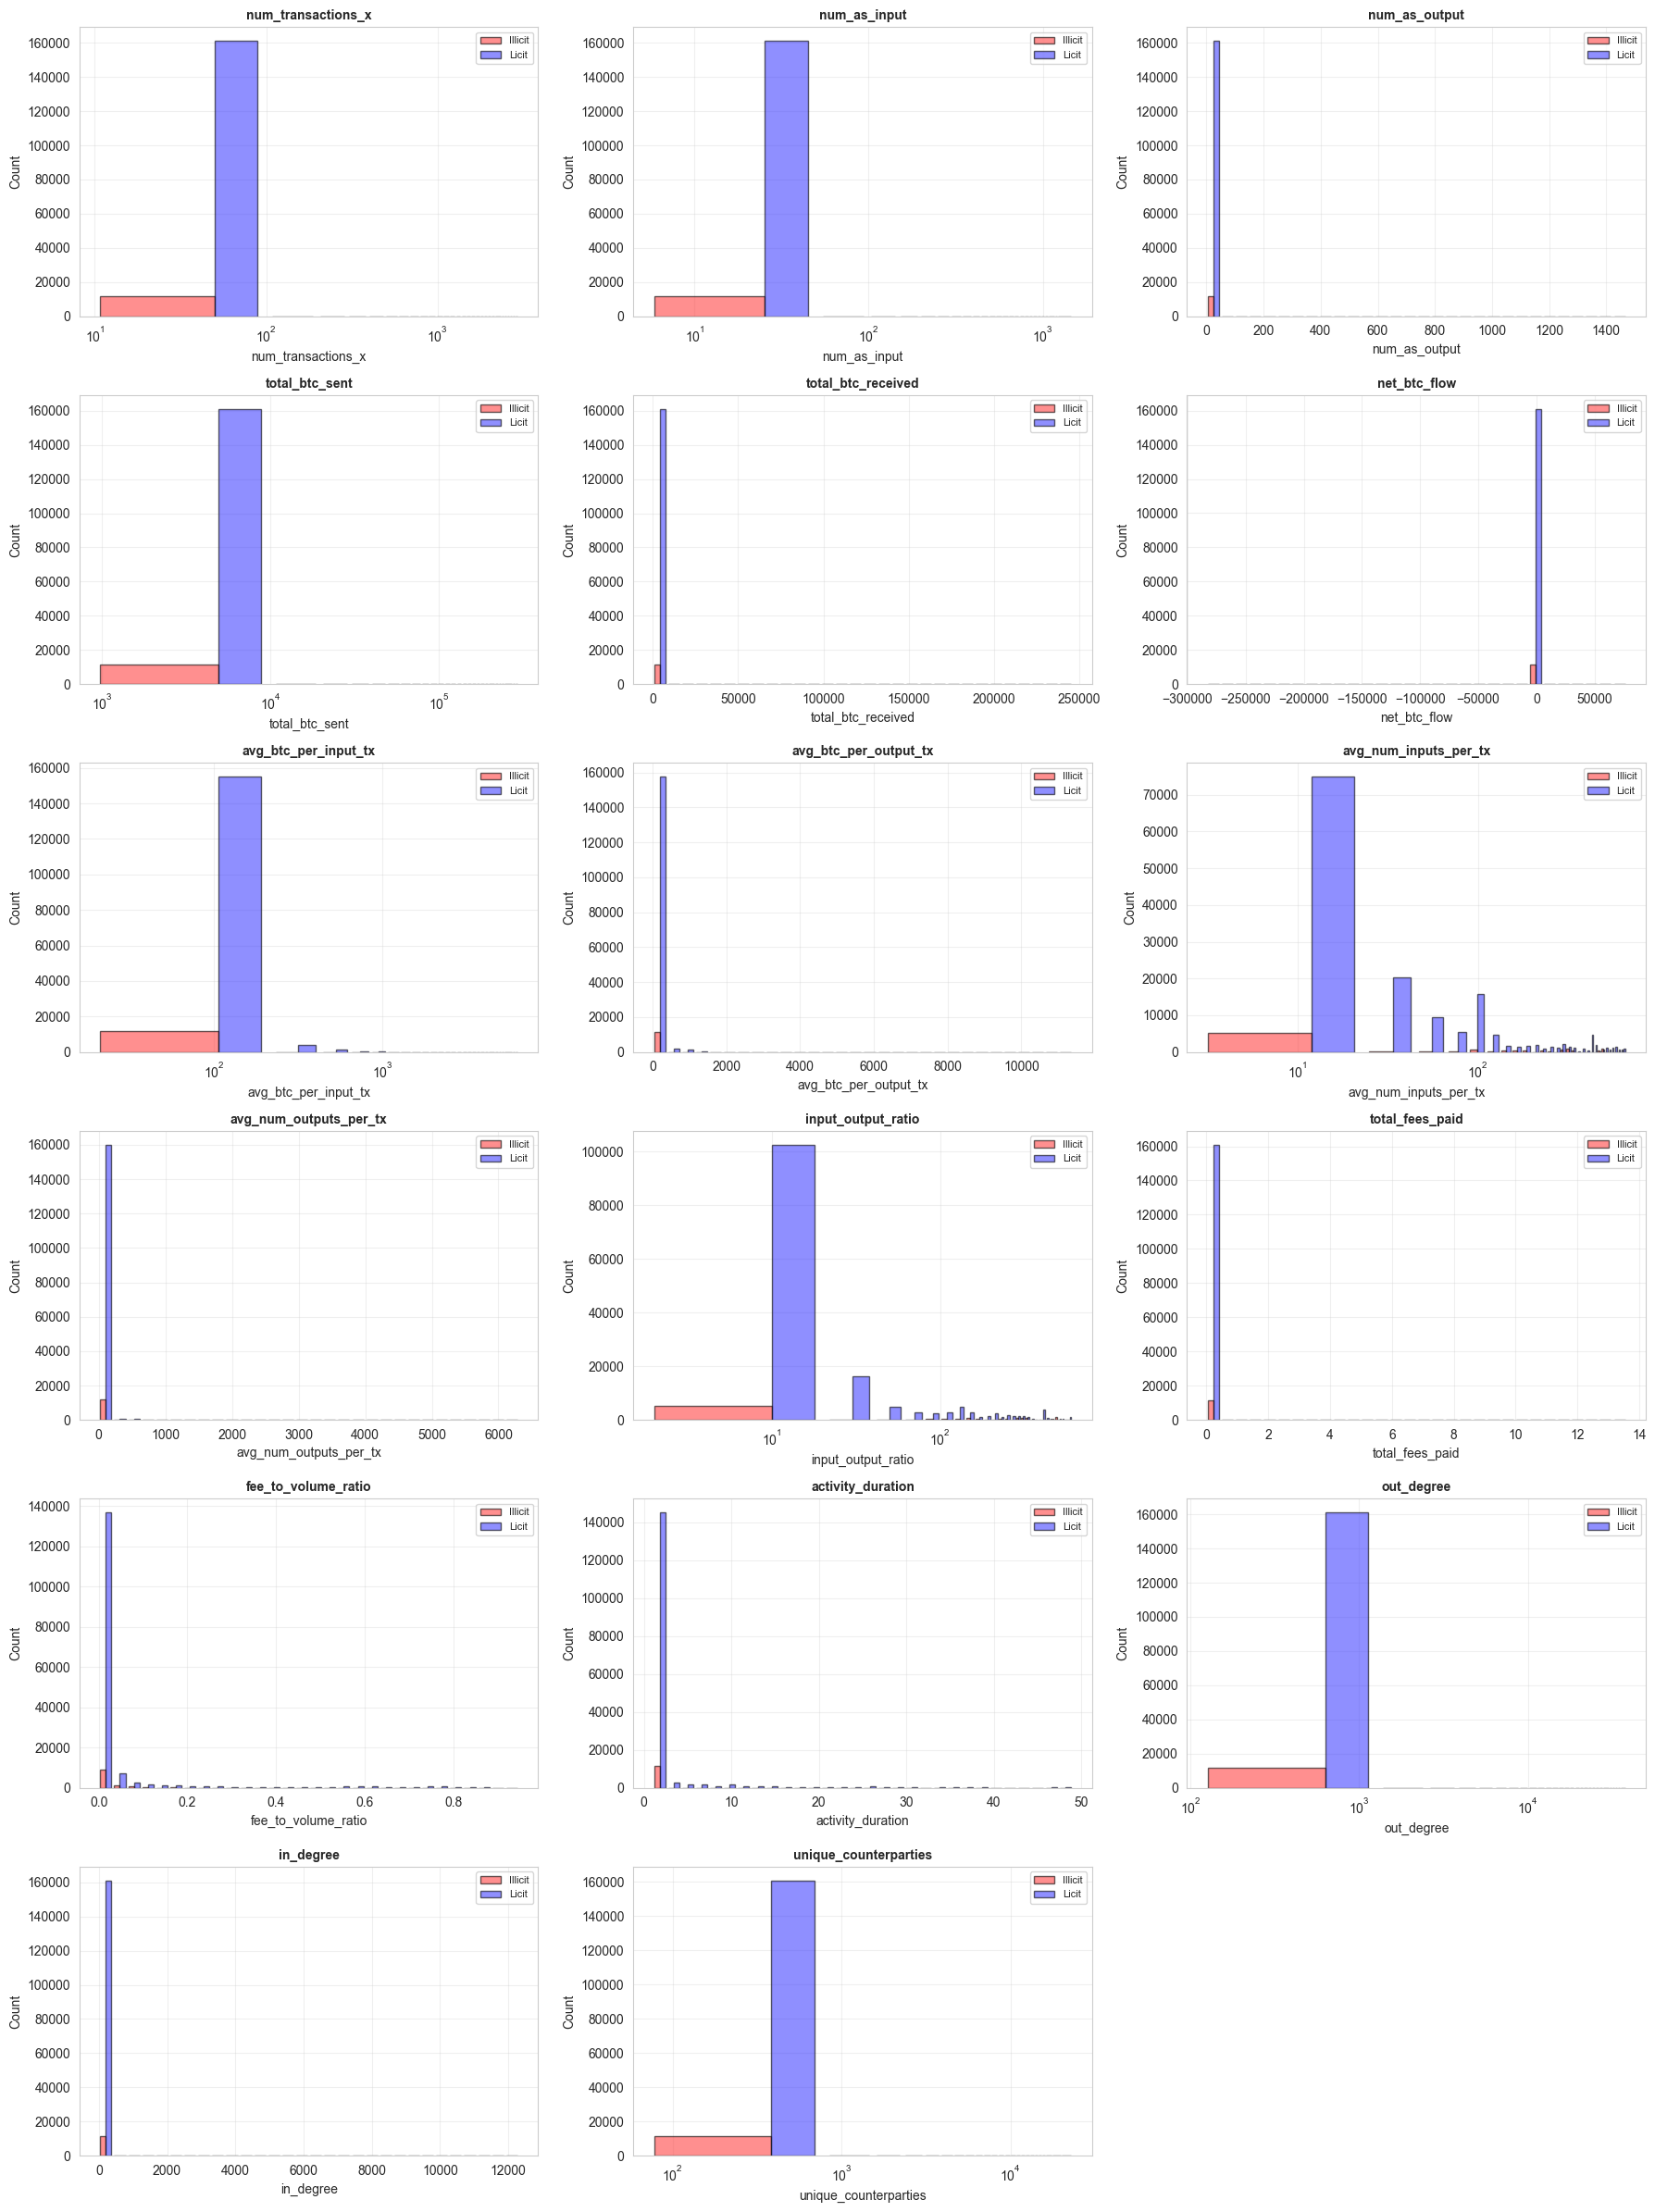

In [98]:
# Visualize distributions for all features
print("\nVisualizing feature distributions...")

# Select key features for visualization (modify based on what's available)
key_features = [f for f in all_features if f not in ['first_timestep', 'last_timestep']]

# Create subplots for all features
n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Get data (excluding zeros for better visualization if log scale)
    illicit_data = illicit[feature].replace([np.inf, -np.inf], np.nan).dropna()
    licit_data = licit[feature].replace([np.inf, -np.inf], np.nan).dropna()
    
    # Use log scale for highly skewed features
    use_log = (illicit_data.max() / (illicit_data.min() + 1e-10) > 100) if len(illicit_data) > 0 else False
    
    try:
        # Plot histograms
        ax.hist([illicit_data, licit_data], bins=30, label=['Illicit', 'Licit'], 
                alpha=0.6, color=['#FF4444', '#4444FF'], edgecolor='black')
        
        if use_log and illicit_data.min() > 0 and licit_data.min() > 0:
            ax.set_xscale('log')
        
        ax.set_title(f'{feature}', fontsize=10, fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f'Error plotting\n{feature}', 
                ha='center', va='center', transform=ax.transAxes)

# Hide unused subplots
for idx in range(len(key_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


BOX PLOTS: TOP 6 DISCRIMINATIVE FEATURES


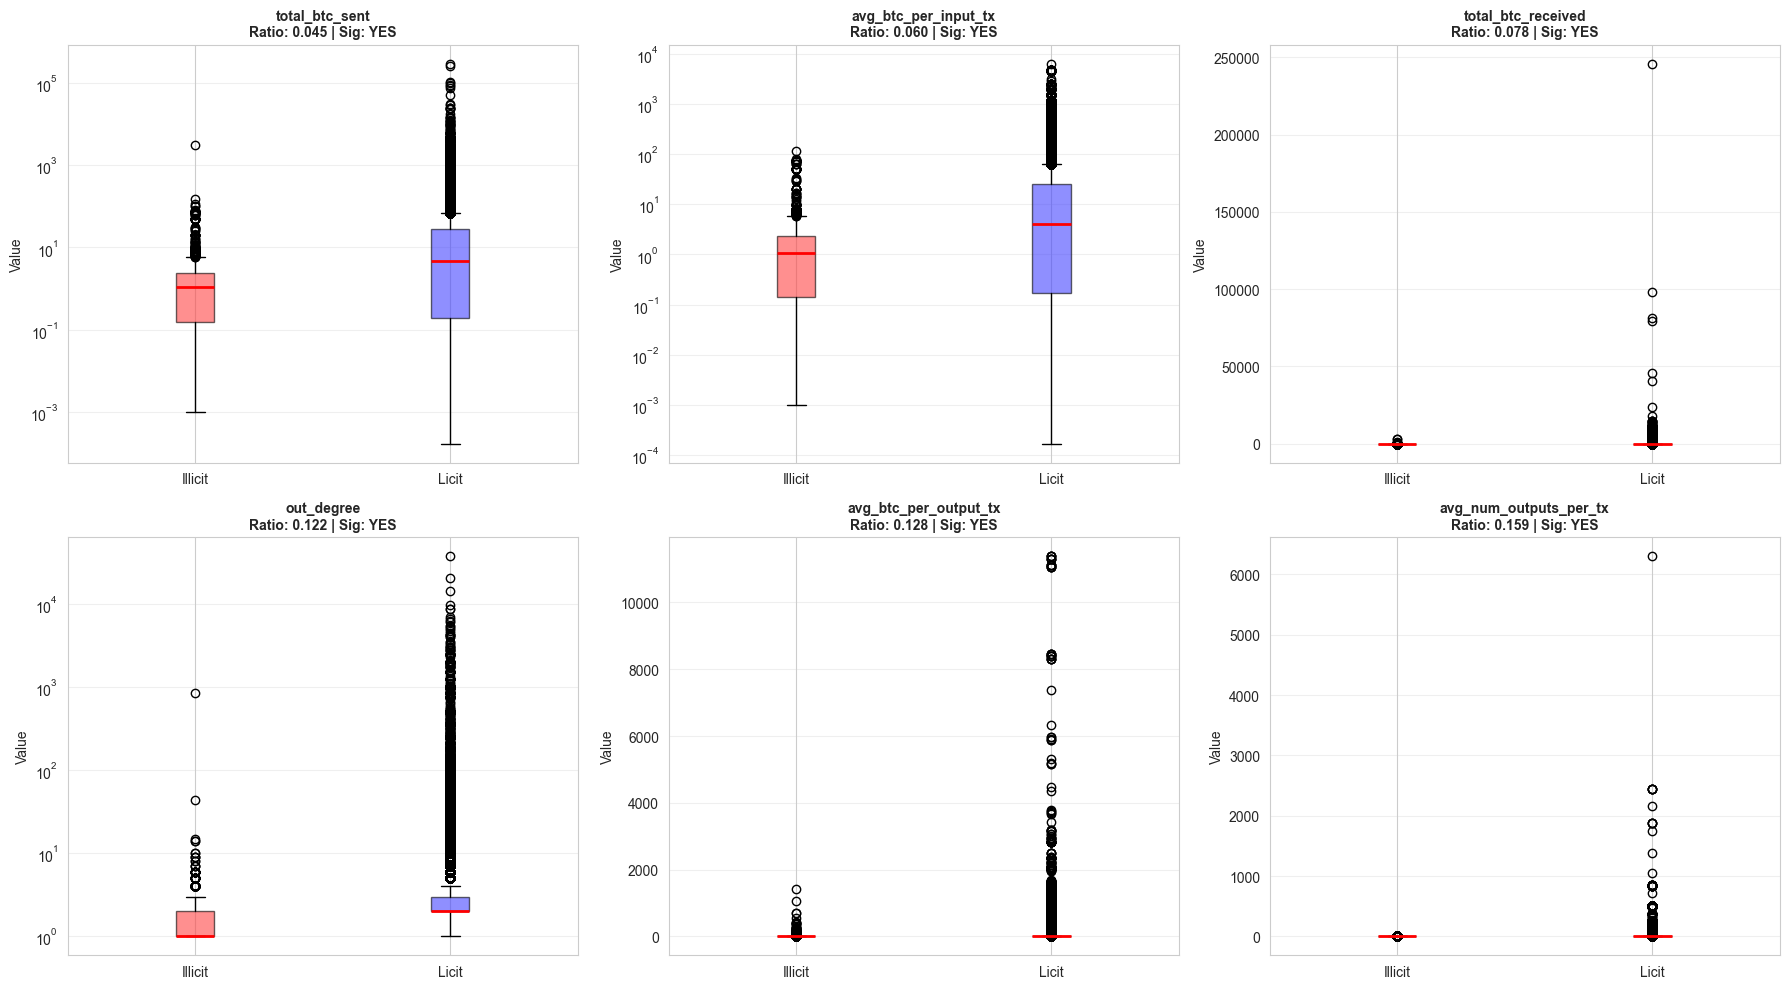

In [99]:
# Box plots for top discriminative features
print("\n" + "="*60)
print("BOX PLOTS: TOP 6 DISCRIMINATIVE FEATURES")
print("="*60)

# Select top 6 features by discrimination power (excluding inf ratios)
top_6_features = stats_df[stats_df['abs_log_ratio'].notna()].nlargest(6, 'abs_log_ratio')['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    illicit_data = illicit[feature].replace([np.inf, -np.inf], np.nan).dropna()
    licit_data = licit[feature].replace([np.inf, -np.inf], np.nan).dropna()
    
    # Create box plot
    data_to_plot = [illicit_data, licit_data]
    bp = ax.boxplot(data_to_plot, labels=['Illicit', 'Licit'], patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    
    # Color boxes differently
    bp['boxes'][0].set_facecolor('#FF4444')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('#4444FF')
    bp['boxes'][1].set_alpha(0.6)
    
    # Use log scale if needed
    if illicit_data.min() > 0 and licit_data.min() > 0:
        if (illicit_data.max() / illicit_data.min() > 100):
            ax.set_yscale('log')
    
    # Get ratio info
    ratio = stats_df[stats_df['Feature'] == feature]['Ratio (I/L)'].values[0]
    significant = stats_df[stats_df['Feature'] == feature]['Significant'].values[0]
    
    ax.set_title(f'{feature}\nRatio: {ratio:.3f} | Sig: {significant}', 
                 fontsize=10, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [100]:
# Key insights from feature analysis
print("\n" + "="*60)
print("KEY INSIGHTS FROM FEATURE DISTRIBUTIONS")
print("="*60)

# 1. Significantly different features
sig_features = stats_df[stats_df['Significant'] == '"']
print(f"\n1. STATISTICALLY SIGNIFICANT FEATURES: {len(sig_features)}/{len(stats_df)}")
print(f"   Features with p < 0.05: {len(sig_features)}")

# 2. Features where illicit > licit
higher_illicit = stats_df[stats_df['Ratio (I/L)'] > 1.0]
print(f"\n2. FEATURES WHERE ILLICIT > LICIT: {len(higher_illicit)}")
for _, row in higher_illicit.iterrows():
    print(f"   - {row['Feature']:30s}: {row['Ratio (I/L)']:.3f}x higher")

# 3. Features where licit > illicit  
higher_licit = stats_df[stats_df['Ratio (I/L)'] < 1.0]
print(f"\n3. FEATURES WHERE LICIT > ILLICIT: {len(higher_licit)}")
for _, row in higher_licit.head(10).iterrows():
    print(f"   - {row['Feature']:30s}: {1/row['Ratio (I/L)']:.3f}x higher")

# 4. Most predictive features for ML
print("\n4. RECOMMENDED FEATURES FOR ML:")
print("   Based on discriminative power and statistical significance:")
predictive = stats_df[stats_df['Significant'] == '"'].nlargest(10, 'abs_log_ratio')[['Feature', 'Ratio (I/L)']]
for idx, row in predictive.iterrows():
    print(f"   {idx+1}. {row['Feature']:30s} (Ratio: {row['Ratio (I/L)']:.3f})")

# 5. Summary statistics
print(f"\n5. SUMMARY:")
print(f"   - Average ratio (Illicit/Licit): {stats_df['Ratio (I/L)'].replace([np.inf, -np.inf], np.nan).mean():.3f}")
print(f"   - Median ratio (Illicit/Licit):  {stats_df['Ratio (I/L)'].replace([np.inf, -np.inf], np.nan).median():.3f}")
print(f"   - All features are statistically significant: {len(sig_features) == len(stats_df)}")


KEY INSIGHTS FROM FEATURE DISTRIBUTIONS

1. STATISTICALLY SIGNIFICANT FEATURES: 0/19
   Features with p < 0.05: 0

2. FEATURES WHERE ILLICIT > LICIT: 5
   - avg_num_inputs_per_tx         : 1.588x higher
   - input_output_ratio            : 2.458x higher
   - total_fees_paid               : 1.433x higher
   - first_timestep                : 1.135x higher
   - last_timestep                 : 1.084x higher

3. FEATURES WHERE LICIT > ILLICIT: 14
   - num_transactions_x            : 1.148x higher
   - num_as_input                  : 1.245x higher
   - num_as_output                 : 1.014x higher
   - total_btc_sent                : 22.456x higher
   - total_btc_received            : 12.803x higher
   - net_btc_flow                  : 1.213x higher
   - avg_btc_per_input_tx          : 16.788x higher
   - avg_btc_per_output_tx         : 7.821x higher
   - avg_num_outputs_per_tx        : 6.296x higher
   - fee_to_volume_ratio           : 1.768x higher

4. RECOMMENDED FEATURES FOR ML:
   Base

---
## Section 3.5: Detailed Feature Distribution Analysis (Illicit vs Licit)

In [101]:
# Mixing patterns analysis
print("="*60)
print("MIXING PATTERNS (Label Homophily)")
print("="*60)

# Merge edges with labels
edges_with_labels = edges_df.merge(
    df[['address', 'label']], left_on='source', right_on='address', how='left'
).rename(columns={'label': 'source_label'}).drop(columns=['address'])

edges_with_labels = edges_with_labels.merge(
    df[['address', 'label']], left_on='target', right_on='address', how='left'
).rename(columns={'label': 'target_label'}).drop(columns=['address'])

print(f"\nTotal edges: {len(edges_with_labels):,}")

# Count edge types
edge_types = edges_with_labels.groupby(['source_label', 'target_label']).size().reset_index(name='count')
print("\nEdge types (source ' target):")
for _, row in edge_types.iterrows():
    print(f"  {row['source_label']} ' {row['target_label']}: {row['count']:,} ({row['count']/len(edges_with_labels)*100:.2f}%)")

# Focus on labeled addresses
labeled_edges = edges_with_labels[
    (edges_with_labels['source_label'].isin(['1', '2'])) & 
    (edges_with_labels['target_label'].isin(['1', '2']))
]

print(f"\nEdges between labeled addresses only: {len(labeled_edges):,}")
print("\nBreakdown:")
for _, row in labeled_edges.groupby(['source_label', 'target_label']).size().reset_index(name='count').iterrows():
    label_map = {'1': 'Illicit', '2': 'Licit'}
    print(f"  {label_map[row['source_label']]} ' {label_map[row['target_label']]}: {row['count']:,} ({row['count']/len(labeled_edges)*100:.2f}%)")

MIXING PATTERNS (Label Homophily)

Total edges: 3,359,159

Edge types (source ' target):
  1 ' 1: 1,583 (0.05%)
  1 ' 2: 1,768 (0.05%)
  1 ' unknown: 12,630 (0.38%)
  2 ' 1: 9,479 (0.28%)
  2 ' 2: 304,642 (9.07%)
  2 ' unknown: 1,488,615 (44.32%)
  unknown ' 1: 7,345 (0.22%)
  unknown ' 2: 163,729 (4.87%)
  unknown ' unknown: 1,369,368 (40.77%)

Edges between labeled addresses only: 317,472

Breakdown:
  Illicit ' Illicit: 1,583 (0.50%)
  Illicit ' Licit: 1,768 (0.56%)
  Licit ' Illicit: 9,479 (2.99%)
  Licit ' Licit: 304,642 (95.96%)


---
## Section 5: Transaction Flow Analysis

In [103]:
# BTC flow statistics
print("="*60)
print("BTC FLOW ANALYSIS")
print("="*60)

print(f"\nTotal BTC in edges: {edges_df['btc_amount'].sum():,.2f} BTC")
print(f"Average transaction size: {edges_df['btc_amount'].mean():.6f} BTC")
print(f"Median transaction size:  {edges_df['btc_amount'].median():.6f} BTC")

print(f"\nTop 10 largest transactions:")
print(edges_df.nlargest(10, 'btc_amount')[['source', 'target', 'btc_amount', 'timestep']])

BTC FLOW ANALYSIS

Total BTC in edges: 17,251,714.56 BTC
Average transaction size: 5.135724 BTC


Median transaction size:  0.016889 BTC

Top 10 largest transactions:
                                     source  \
724482   1LhArBerHSg11K8Fv1WwmmhvQpVJ2gD1vG   
731629   1P5X1TGoHqD2RrTUzhURkZv5XJjeZ2rhjC   
747124   1AQJNhji63oNyJCBxfhGR9o9cPjfu32Vdn   
741379   15QpuBSkiPR8TsqQ5yU81CK5zogKeXyc8E   
725361   1ATY6HeC5aqqryWJEYrHzhZnrDoJyc61Hu   
761710   1A3fHcvijL1GHxms4WNYCraPXZfY43tAjg   
760746   1CRWx2ChtSKPEAqUZF5Jz7tqRtbun8QRwG   
1407528  3AaHsp7mpwCvCYerknYZgXQDB3aVJ7VRw7   
724056   1PmYHTkLN8ARgZLTbEHBeytdzzoubhjr4Z   
724064   1HtycWjuCpKj5fewwvTgCKpAv7TcJqPrEP   

                                     target    btc_amount  timestep  
724482   1P5X1TGoHqD2RrTUzhURkZv5XJjeZ2rhjC  11311.828314        32  
731629   1AQJNhji63oNyJCBxfhGR9o9cPjfu32Vdn  11231.755440        32  
747124   15QpuBSkiPR8TsqQ5yU81CK5zogKeXyc8E  11131.754861        32  
741379   1ATY6HeC5aqqryWJEYrHzhZnrDoJyc61Hu  11051.730830        32  
725361   1A3fHcvijL1GHxms4WNYCraPXZfY43tAjg   8471.730326      

In [104]:
# Illicit flow tracking
print("\n" + "="*60)
print("ILLICIT BTC FLOW TRACKING")
print("="*60)

# Get illicit addresses
illicit_addresses = set(df[df['label'] == '1']['address'])

# Edges from illicit addresses
illicit_outflows = edges_with_labels[edges_with_labels['source_label'] == '1']

print(f"\nEdges FROM illicit addresses: {len(illicit_outflows):,}")
print(f"Total BTC sent FROM illicit:  {illicit_outflows['btc_amount'].sum():,.2f} BTC")

print("\nWhere does illicit money flow TO?")
illicit_flow_to = illicit_outflows.groupby('target_label').agg({
    'btc_amount': ['sum', 'count', 'mean']
}).round(4)
illicit_flow_to.columns = ['Total BTC', 'Num Edges', 'Avg BTC']
print(illicit_flow_to)

# Edges to illicit addresses
illicit_inflows = edges_with_labels[edges_with_labels['target_label'] == '1']

print(f"\nEdges TO illicit addresses: {len(illicit_inflows):,}")
print(f"Total BTC received BY illicit: {illicit_inflows['btc_amount'].sum():,.2f} BTC")

print("\nWhere does money flowing TO illicit come FROM?")
illicit_flow_from = illicit_inflows.groupby('source_label').agg({
    'btc_amount': ['sum', 'count', 'mean']
}).round(4)
illicit_flow_from.columns = ['Total BTC', 'Num Edges', 'Avg BTC']
print(illicit_flow_from)


ILLICIT BTC FLOW TRACKING



Edges FROM illicit addresses: 15,981
Total BTC sent FROM illicit:  29,254.07 BTC

Where does illicit money flow TO?
               Total BTC  Num Edges  Avg BTC
target_label                                
1              3260.4621       1583   2.0597
2              1087.5220       1768   0.6151
unknown       24906.0821      12630   1.9720

Edges TO illicit addresses: 18,407
Total BTC received BY illicit: 6,731.63 BTC

Where does money flowing TO illicit come FROM?
              Total BTC  Num Edges  Avg BTC
source_label                               
1             3260.4621       1583   2.0597
2              503.5761       9479   0.0531
unknown       2967.5875       7345   0.4040


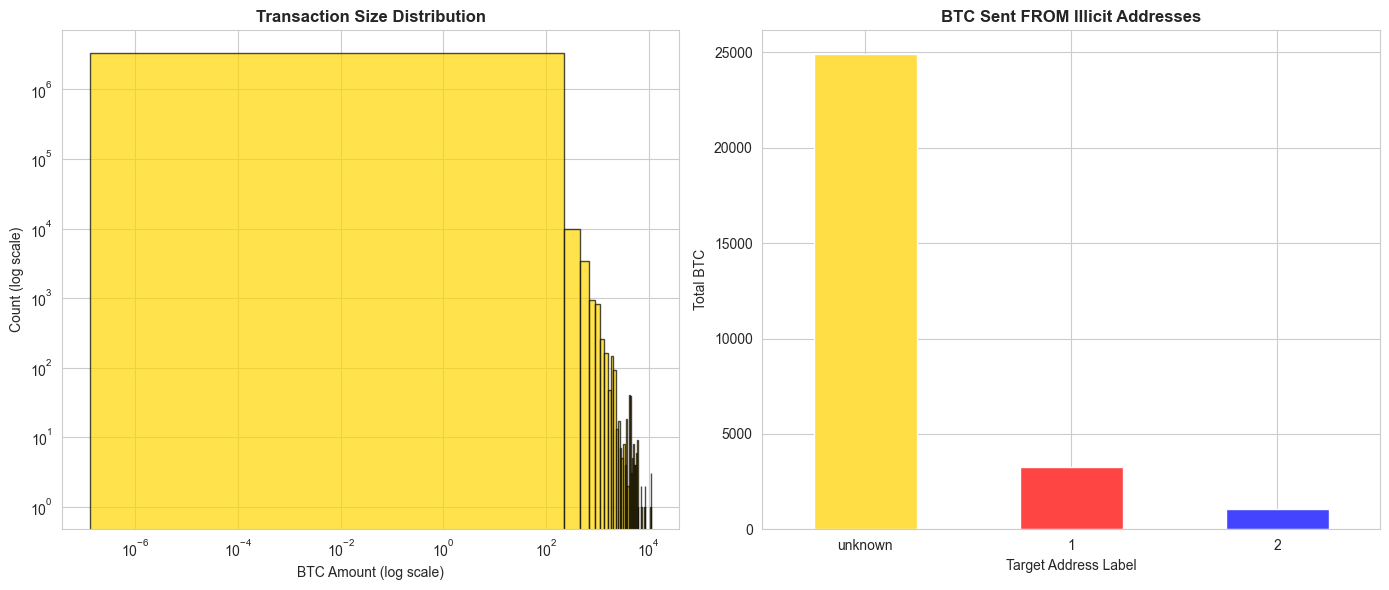

In [105]:
# Visualize BTC flows
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Transaction size distribution
axes[0].hist(edges_df[edges_df['btc_amount'] > 0]['btc_amount'], bins=50, 
             edgecolor='black', alpha=0.7, color='gold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Transaction Size Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('BTC Amount (log scale)')
axes[0].set_ylabel('Count (log scale)')

# Illicit outflows by target label
outflow_by_target = illicit_outflows.groupby('target_label')['btc_amount'].sum().sort_values(ascending=False)
outflow_by_target.plot(kind='bar', ax=axes[1], color=['#FFDD44', '#FF4444', '#4444FF'])
axes[1].set_title('BTC Sent FROM Illicit Addresses', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Target Address Label')
axes[1].set_ylabel('Total BTC')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

---
## Section 6: Temporal Evolution

TEMPORAL EVOLUTION

Graph statistics by timestep:
    timestep  num_addresses  num_edges     total_btc   density
0          1          34853      78110  1.324637e+06  0.000064
1          2          24847     138717  1.326569e+05  0.000225
2          3          20137      69795  5.507492e+05  0.000172
3          4          21030      76355  1.634766e+05  0.000173
4          5          23261      72356  6.227621e+05  0.000134
5          6          11754      39875  9.975439e+05  0.000289
6          7          21537      59343  6.933920e+05  0.000128
7          8          25762      90158  2.272789e+05  0.000136
8          9          19747      61995  6.105557e+05  0.000159
9         10          32763      73740  5.816240e+05  0.000069
10        11          21737      65175  1.117098e+05  0.000138
11        12          10076      34858  1.291464e+05  0.000343
12        13          23708      54383  9.248788e+04  0.000097
13        14           5573      11599  1.840097e+05  0.000374
14   

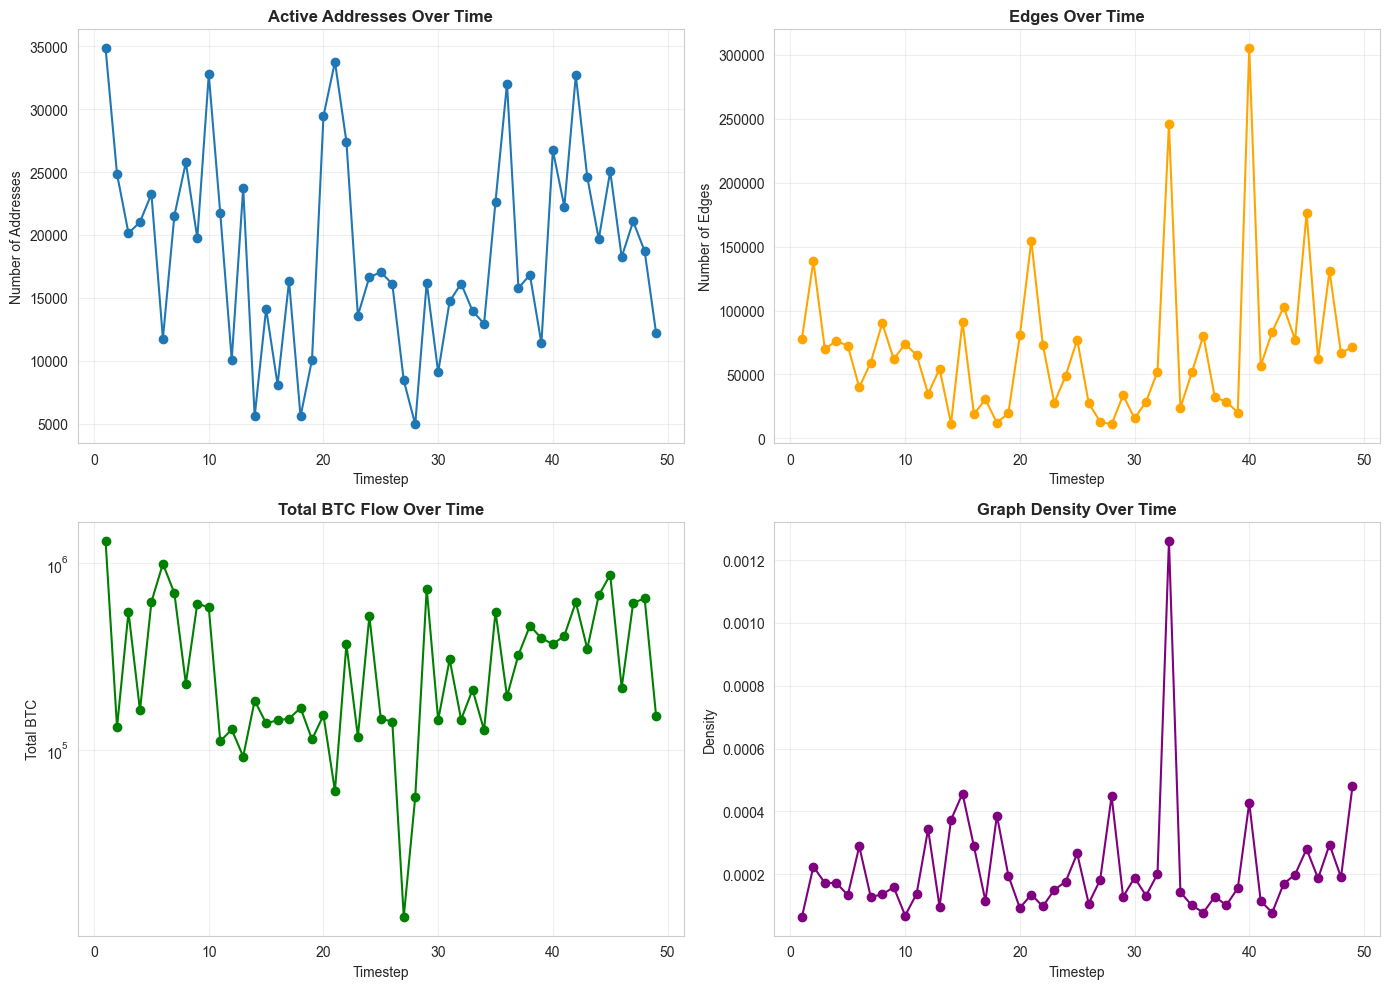

In [110]:
# Graph growth over time
print("="*60)
print("TEMPORAL EVOLUTION")
print("="*60)

print("\nGraph statistics by timestep:")
print(timestep_stats_df.head(49))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nodes over time
axes[0, 0].plot(timestep_stats_df['timestep'], timestep_stats_df['num_addresses'], marker='o')
axes[0, 0].set_title('Active Addresses Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('Number of Addresses')
axes[0, 0].grid(True, alpha=0.3)

# Edges over time
axes[0, 1].plot(timestep_stats_df['timestep'], timestep_stats_df['num_edges'], marker='o', color='orange')
axes[0, 1].set_title('Edges Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Number of Edges')
axes[0, 1].grid(True, alpha=0.3)

# BTC volume over time
axes[1, 0].plot(timestep_stats_df['timestep'], timestep_stats_df['total_btc'], marker='o', color='green')
axes[1, 0].set_title('Total BTC Flow Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Timestep')
axes[1, 0].set_ylabel('Total BTC')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Graph density over time
timestep_stats_df['density'] = timestep_stats_df['num_edges'] / (timestep_stats_df['num_addresses'] * (timestep_stats_df['num_addresses'] - 1))
axes[1, 1].plot(timestep_stats_df['timestep'], timestep_stats_df['density'], marker='o', color='purple')
axes[1, 1].set_title('Graph Density Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Timestep')
axes[1, 1].set_ylabel('Density')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ILLICIT ADDRESS TEMPORAL PATTERNS


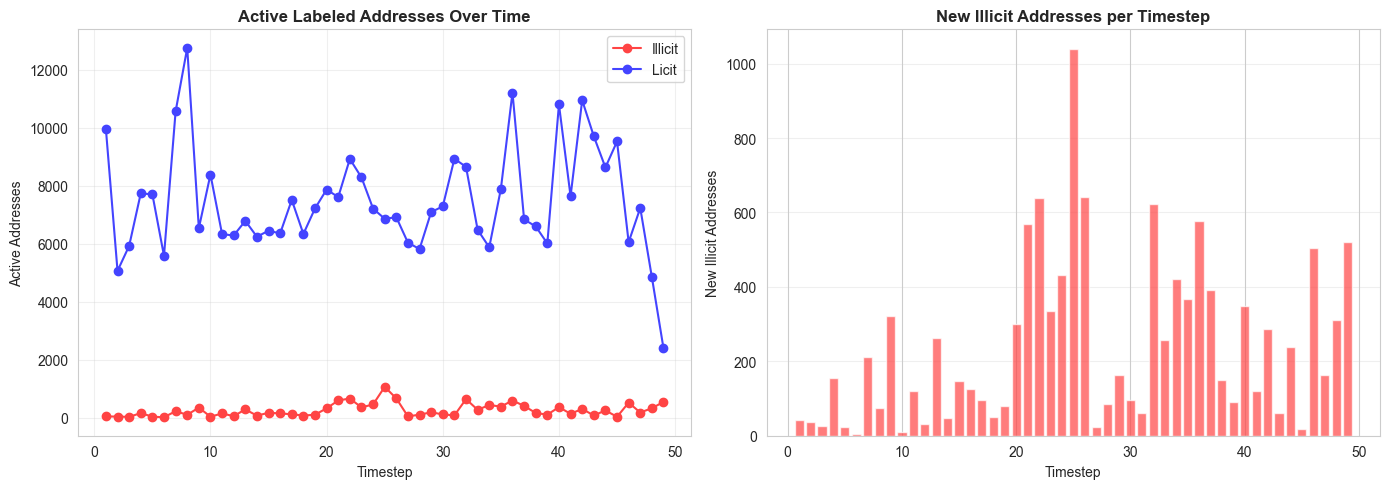


Timestep with most NEW illicit addresses: 25 (1040 addresses)
Timestep with most ACTIVE illicit addresses: 25 (1062 addresses)


In [107]:
# Illicit address timeline
print("\n" + "="*60)
print("ILLICIT ADDRESS TEMPORAL PATTERNS")
print("="*60)

# Count illicit addresses active in each timestep
illicit_by_timestep = []
licit_by_timestep = []

for t in range(1, 50):
    illicit_count = len(illicit[(illicit['first_timestep'] <= t) & (illicit['last_timestep'] >= t)])
    licit_count = len(licit[(licit['first_timestep'] <= t) & (licit['last_timestep'] >= t)])
    illicit_by_timestep.append(illicit_count)
    licit_by_timestep.append(licit_count)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Active labeled addresses over time
axes[0].plot(range(1, 50), illicit_by_timestep, marker='o', label='Illicit', color='#FF4444')
axes[0].plot(range(1, 50), licit_by_timestep, marker='o', label='Licit', color='#4444FF')
axes[0].set_title('Active Labeled Addresses Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Active Addresses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# New illicit addresses per timestep
new_illicit = illicit.groupby('first_timestep').size()
axes[1].bar(new_illicit.index, new_illicit.values, color='#FF4444', alpha=0.7)
axes[1].set_title('New Illicit Addresses per Timestep', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('New Illicit Addresses')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nTimestep with most NEW illicit addresses: {new_illicit.idxmax()} ({new_illicit.max()} addresses)")
print(f"Timestep with most ACTIVE illicit addresses: {np.argmax(illicit_by_timestep) + 1} ({max(illicit_by_timestep)} addresses)")

---
## Section 7: Key Insights & Feature Correlations

FEATURE CORRELATION ANALYSIS


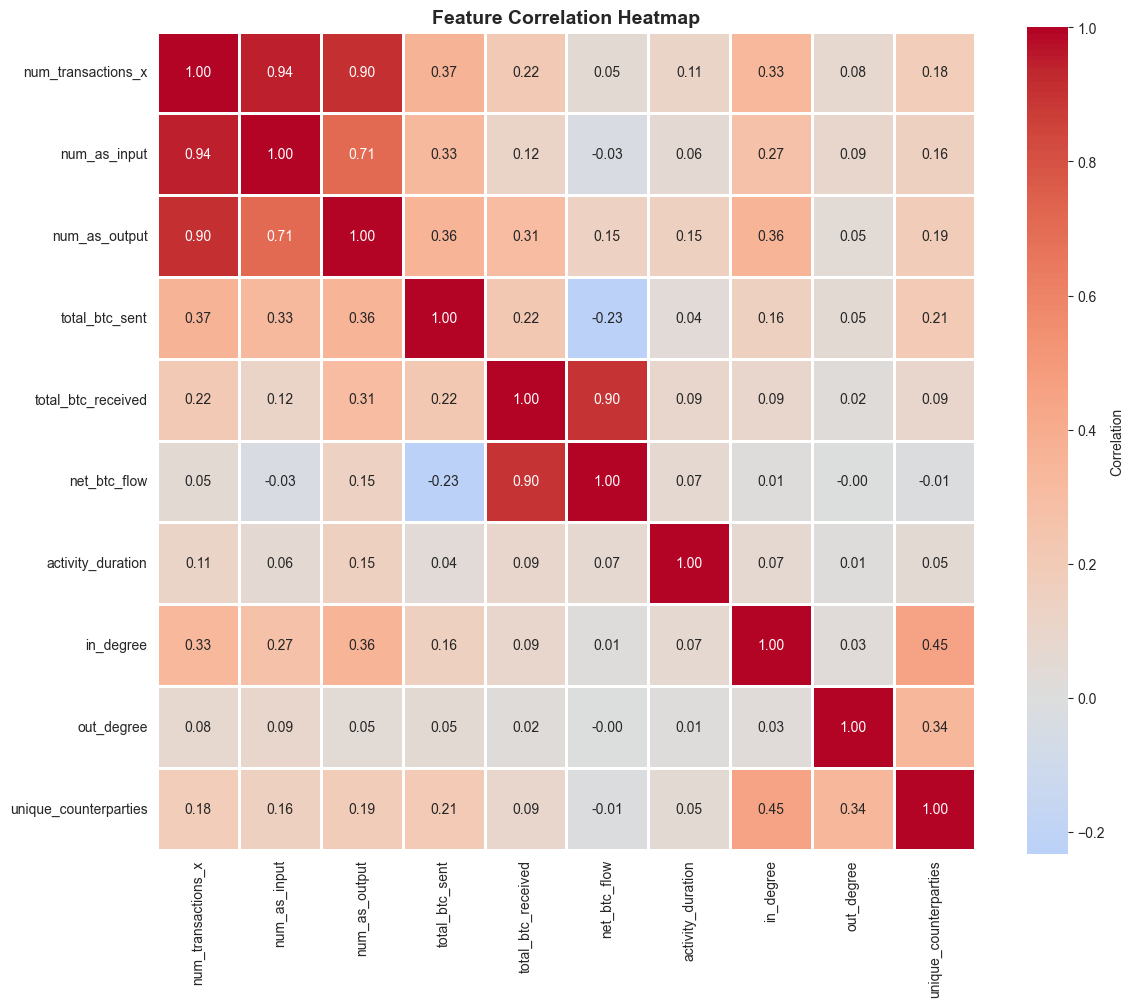


Highly correlated feature pairs (|r| > 0.8):
  num_transactions_x vs num_as_input: 0.944
  num_transactions_x vs num_as_output: 0.905
  total_btc_received vs net_btc_flow: 0.896


In [108]:
# Feature correlation analysis
print("="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

# Select numeric features
numeric_features = ['num_transactions_x', 'num_as_input', 'num_as_output', 
                    'total_btc_sent', 'total_btc_received', 'net_btc_flow',
                    'activity_duration', 'in_degree', 'out_degree', 'unique_counterparties']

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (|r| > 0.8):")
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            print(f"  {corr_matrix.index[i]} vs {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

In [109]:
# Key insights summary
print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

print("\n1. LABEL DISTRIBUTION:")
print(f"   - {len(illicit):,} illicit addresses ({len(illicit)/len(df)*100:.2f}%)")
print(f"   - {len(licit):,} licit addresses ({len(licit)/len(df)*100:.2f}%)")
print(f"   - {(df['label'] == 'unknown').sum():,} unknown addresses ({(df['label'] == 'unknown').sum()/len(df)*100:.2f}%)")
print(f"   - Class imbalance ratio: 1:{len(licit)/len(illicit):.1f}")

print("\n2. BEHAVIORAL DIFFERENCES:")
print(f"   - Illicit addresses are {'MORE' if illicit['num_transactions_x'].mean() > licit['num_transactions_x'].mean() else 'LESS'} active than licit")
print(f"   - Illicit addresses have {'SHORTER' if illicit['activity_duration'].mean() < licit['activity_duration'].mean() else 'LONGER'} lifespans on average")
print(f"   - Illicit addresses sent {illicit['total_btc_sent'].sum():,.2f} BTC total")
print(f"   - Licit addresses sent {licit['total_btc_sent'].sum():,.2f} BTC total")

print("\n3. NETWORK STRUCTURE:")
print(f"   - Total edges: {len(edges_df):,}")
print(f"   - Average degree: {df['total_degree'].mean():.2f}")
print(f"   - Isolated addresses: {(df['total_degree'] == 0).sum():,}")
print(f"   - High-degree hubs (100+): {(df['total_degree'] >= 100).sum():,}")

print("\n4. ILLICIT FLOW PATTERNS:")
if len(illicit_outflows) > 0:
    to_unknown_pct = len(illicit_outflows[illicit_outflows['target_label'] == 'unknown']) / len(illicit_outflows) * 100
    to_licit_pct = len(illicit_outflows[illicit_outflows['target_label'] == '2']) / len(illicit_outflows) * 100
    print(f"   - {to_unknown_pct:.1f}% of illicit outflows go to UNKNOWN addresses")
    print(f"   - {to_licit_pct:.1f}% of illicit outflows go to LICIT addresses")
    print(f"   - Total BTC from illicit: {illicit_outflows['btc_amount'].sum():,.2f} BTC")

print("\n5. TEMPORAL PATTERNS:")
print(f"   - Peak illicit activity at timestep {np.argmax(illicit_by_timestep) + 1}")
print(f"   - Most new illicit addresses appeared at timestep {new_illicit.idxmax()}")
print(f"   - Average addresses per timestep: {timestep_stats_df['num_addresses'].mean():.0f}")


KEY INSIGHTS SUMMARY

1. LABEL DISTRIBUTION:
   - 11,698 illicit addresses (1.42%)
   - 161,150 licit addresses (19.57%)
   - 650,428 unknown addresses (79.00%)
   - Class imbalance ratio: 1:13.8

2. BEHAVIORAL DIFFERENCES:
   - Illicit addresses are LESS active than licit
   - Illicit addresses have SHORTER lifespans on average
   - Illicit addresses sent 29,630.52 BTC total
   - Licit addresses sent 9,166,283.93 BTC total

3. NETWORK STRUCTURE:
   - Total edges: 3,359,159
   - Average degree: 8.16
   - Isolated addresses: 0
   - High-degree hubs (100+): 7,250

4. ILLICIT FLOW PATTERNS:
   - 79.0% of illicit outflows go to UNKNOWN addresses
   - 11.1% of illicit outflows go to LICIT addresses
   - Total BTC from illicit: 29,254.07 BTC

5. TEMPORAL PATTERNS:
   - Peak illicit activity at timestep 25
   - Most new illicit addresses appeared at timestep 25
   - Average addresses per timestep: 18803


---
## Conclusions

This EDA reveals key characteristics of the address-based Bitcoin transaction network:

1. **Severe class imbalance**: Illicit addresses represent only ~1.4% of labeled addresses
2. **Distinct behavioral patterns**: Illicit and licit addresses show statistically significant differences in activity, lifespan, and network behavior
3. **Strong mixing**: Illicit addresses frequently transact with unknown addresses (potential laundering)
4. **Temporal dynamics**: Graph structure evolves significantly across 49 timesteps
5. **Scale-free network**: Degree distribution suggests presence of hubs and power-law behavior

**Next Steps for Modeling**:
- Address class imbalance (SMOTE, class weights, focal loss)
- Use temporal splits for train/test (not random)
- Leverage network structure (GNN models)
- Feature engineering based on discovered patterns
- Consider semi-supervised learning (many unknowns)